In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import re
import os
import glob
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from keras import backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Resizing, Cropping2D, Input



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Limito la memoria de Tensorflow per poder utilitzar torch.
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
    
#     memory_limit = 14233  # mb
#     for gpu in gpus:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpu,
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])


In [3]:
#rutes
#image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/flood-area-segmentation/Image'
#mask_dir='/kaggle/input/flood-area-segmentation/Mask'
image_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages"
mask_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG"

In [4]:
#os.listdir(image_dir)

In [5]:
## Retallo les imatges per a que s'adequin al tamany necessari pel model.

image_list = []
resized_images = []

directory_path = image_dir
filenames=sorted(glob.glob(os.path.join(directory_path, '*.jpg')))

for filename in filenames:
    #print(filename)
    img = Image.open(filename)
    image_list.append(img)

for image in image_list:
    image = image.resize((590,444))
    resized_images.append(image)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
output_directory='/kaggle/working'
for (i, new) in enumerate(resized_images):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_image', i+1)))


In [6]:
## Retallo les mascares per a que s'adequin al tamany necessari pel model.
masks_list = []
resized_masks = []

directory_path = mask_dir
filenames=sorted(glob.glob(os.path.join(directory_path, '*.png')))

for filename in filenames:
    #print(filename)
    msk = Image.open(filename)
    masks_list.append(msk)

for mask in masks_list:
    mask = mask.resize((590,444))
    resized_masks.append(mask)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
output_directory='/kaggle/working'

for (i, new) in enumerate(resized_masks):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_mask', i+1)))



In [7]:
def load_images_and_masks(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            #Normalitzo les mascares
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0

            # Guardo la imatge i la mascara en un diccionari
            images.append(image)
            masks.append(mask)
                
    return np.array(images),np.array(masks)



In [8]:
# mascares en blanc o negre:

def load_images_and_masks_bw(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            
            umbral = 127  
            mask = np.where(mask > umbral, 255, 0)

           
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)

            # Guardo la imatge y la mascara en un diccionari
            images.append(image)
            masks.append(mask)
                
    return np.array(images), np.array(masks)

In [9]:
# Funció per establir el threshhold de manera diferent
def load_images_and_masks_bw(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Aplica un llindar per convertir la imatge en blanc y negre
            _, image_bw = cv2.threshold(image, 0.1, 1, cv2.THRESH_BINARY)

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            # Aplica un llindar per convertir la màscara en blanc y negre
            _, mask_bw = cv2.threshold(mask, 0.1, 1, cv2.THRESH_BINARY)

            
            mask_bw = mask_bw.reshape(mask_bw.shape[0], mask_bw.shape[1], 1)

            # Guardo la imatge y la mascara en un diccionari
            images.append(image_bw)
            masks.append(mask_bw)
                
    return np.array(images), np.array(masks)

In [10]:
# # Pels altres datasets!!

# def load_images_and_masks(image_dir,mask_dir):
#     images = []
#     masks = []
#     for filename in os.listdir(image_dir):
#         if filename.endswith(".jpg"): #and "image" in filename:
#             # Obtinc el numero d'imatge a partir del nom
#             image_number = re.search(r'\d+', filename).group()

#             # Carrego la imatge
#             image_filename=f"um_{image_number}.jpg"
#             image_path = os.path.join(image_dir, filename)
#             image = np.array(Image.open(image_path))

#             # Carrego la mascara corresponent
#             mask_filename = f"{image_number}.png"
#             mask_path = os.path.join(mask_dir, mask_filename)
#             mask = np.array(Image.open(mask_path).convert('L'))
            
#             #Normalitzo les mascares
#             mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0
            
#             print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")


#             # Guardo la imatge i la mascara en un diccionari
#             images.append(image)
#             masks.append(mask)
                
#     return np.array(images),np.array(masks)

In [11]:
# # Ruta de les imatges
# #image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images/'
# #image_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
image_dir='/kaggle/working'
#image_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages'
#mask_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG'
# Carrego les imatges
images,masks = load_images_and_masks(image_dir)


In [12]:
# def load_masks(mask_dir):
#      masks = []

#      for filename in os.listdir(mask_dir):
#          if filename.endswith(".png") and "mask" in filename:
             
#              mask_path = os.path.join(mask_dir, filename)
#              mask = np.array(Image.open(mask_path).convert("L"))
#              normalized_mask=mask/255.0
             
#              masks.append(normalized_mask)
#      return np.array(masks)



In [13]:
# # Ruta de les mascares
# #masks_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
# #masks_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
#masks_dir="/kaggle/working"


# Carrego les imatges
#masks = load_masks(masks_dir)

In [14]:
# #Ajusto les imatges
# #adjusted_images = images.reshape(-1, 590, 444, 3)
masks = masks.reshape(-1, masks.shape[1], masks.shape[2], 1)

In [15]:
images.shape

(374, 444, 590, 3)

In [16]:
masks.shape

(374, 444, 590, 1)

In [17]:
images_reshaped = images.reshape((-1, 444, 590, 3))
masks_reshaped = masks.reshape((-1, 444, 590, 1))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images_reshaped,masks_reshaped, test_size=0.2, random_state=23)


In [19]:
def dice_coef(y_true, y_pred, smooth=1, th=0.05):
    y_true_f = tf.cast(K.flatten(y_true) > th,"float")
    y_pred_f = tf.cast(K.flatten(y_pred) > th, "float")
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
# Defineixo un Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
#Model
input_shape = (444,590, 3)
num_filters = 32


## Model més simple per mirar de solventar el problema de dimensions.
model = models.Sequential()
    
# Encoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

    
# Decoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef]) #dice coefficient

In [22]:
#### PROVA MODEL MÉS COMPLEX
input_shape = (444, 590, 3)
num_filters = 32

model2 = models.Sequential()

# Encoder
model2.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Additional Encoder Layers
model2.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))


# Decoder
model2.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))


# Additional Decoder Layers
model2.add(layers.Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.UpSampling2D((2, 2)))

model2.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


In [23]:
#Model 3
input_shape = (444, 590, 3)
num_filters = 64

model3 = models.Sequential()

# Encoder
model3.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

# Additional Encoder Layers
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

# Decoder
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))


# Additional Decoder Layers
model3.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(UpSampling2D((2, 2)))
model3.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
#model.add(UpSampling2D((2, 2)))

# Output layer
model3.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
#lineal amb mse.




In [24]:
# Train the model
history=model.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


Epoch 1/50
38/38 [==============================] - 10s 120ms/step - loss: 0.4405 - dice_coef: 0.3715 - val_loss: 0.1591 - val_dice_coef: 0.3054
Epoch 2/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1948 - dice_coef: 0.4581 - val_loss: 0.1369 - val_dice_coef: 0.5355
Epoch 3/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1182 - dice_coef: 0.5982 - val_loss: 0.1485 - val_dice_coef: 0.0780
Epoch 4/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1055 - dice_coef: 0.6718 - val_loss: 0.1232 - val_dice_coef: 0.2291
Epoch 5/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1029 - dice_coef: 0.7017 - val_loss: 0.1057 - val_dice_coef: 0.6059
Epoch 6/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1001 - dice_coef: 0.7384 - val_loss: 0.1082 - val_dice_coef: 0.4707
Epoch 7/50
38/38 [==============================] - 4s 95ms/step - loss: 0.0982 - dice_coef: 0.7630 - val_loss: 0.1034 - val_dice_coef: 0.59

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 444, 590, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 444, 590, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 444, 590, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 222, 295, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 295, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 222, 295, 32)      1

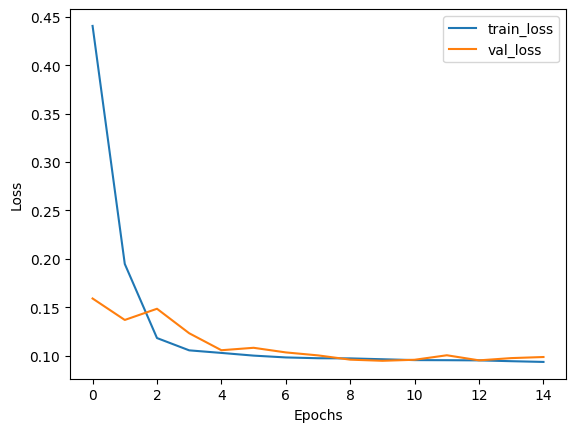

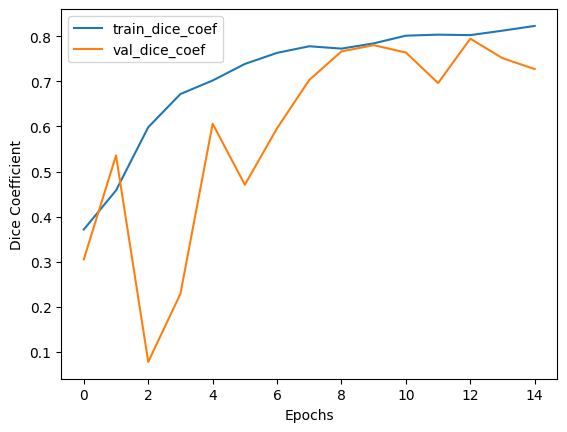

In [26]:
#Faig gràfics per veure com entrena el model
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['dice_coef'], label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

[350, 26, 94, 140, 209]
1/1 [==============================] - 1s 577ms/step


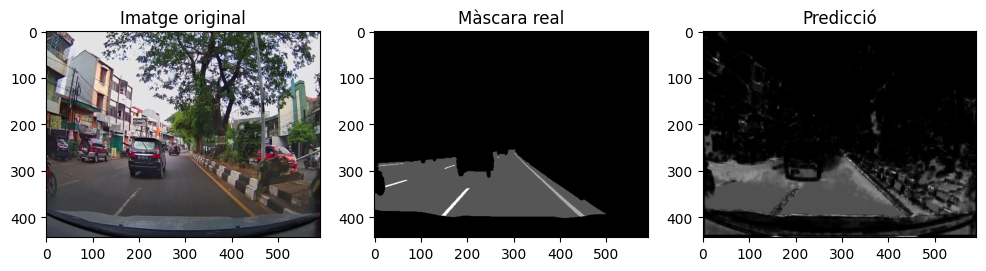

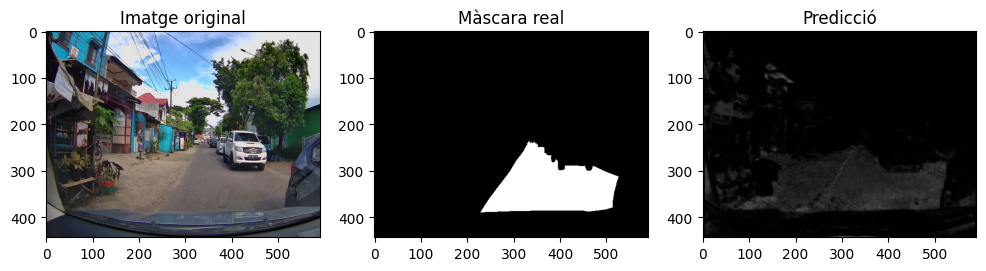

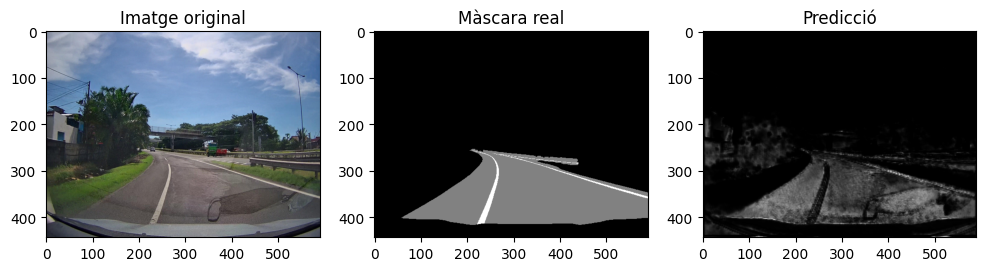

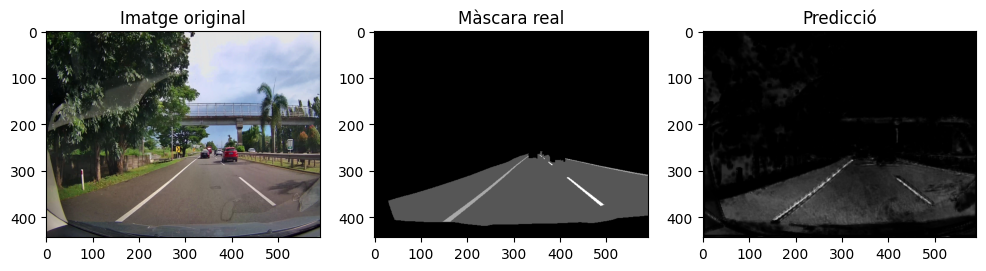

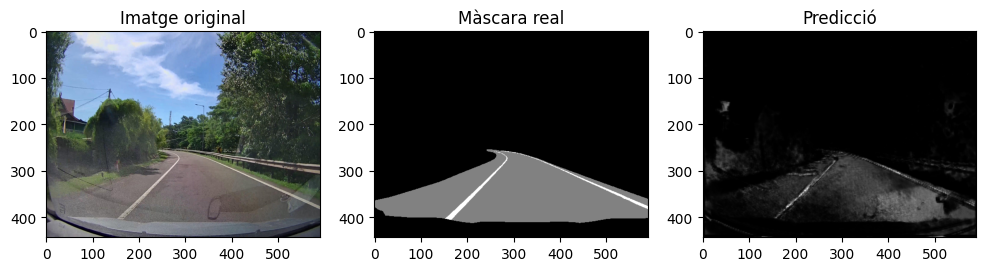

In [27]:
#comprovo com funciona el model agafar de les test
num_samples = 5
sample_indices = random.sample(range(len(images)), num_samples)
print(sample_indices)
sample_images = [images[i] for i in sample_indices]
sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred1 = model.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred1[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()


#200x200

In [28]:
# Model 2

In [29]:

history2=model2.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


Epoch 1/50
38/38 [==============================] - 12s 199ms/step - loss: 0.2172 - dice_coef: 0.4810 - val_loss: 0.1647 - val_dice_coef: 0.4996
Epoch 2/50
38/38 [==============================] - 6s 166ms/step - loss: 0.1006 - dice_coef: 0.7614 - val_loss: 0.2002 - val_dice_coef: 0.4767
Epoch 3/50
38/38 [==============================] - 6s 167ms/step - loss: 0.0956 - dice_coef: 0.8135 - val_loss: 0.2286 - val_dice_coef: 0.4932
Epoch 4/50
38/38 [==============================] - 6s 167ms/step - loss: 0.0944 - dice_coef: 0.8185 - val_loss: 0.2205 - val_dice_coef: 0.4899
Epoch 5/50
38/38 [==============================] - 6s 168ms/step - loss: 0.0923 - dice_coef: 0.8430 - val_loss: 0.1968 - val_dice_coef: 0.5371
Epoch 6/50
38/38 [==============================] - 6s 168ms/step - loss: 0.0909 - dice_coef: 0.8556 - val_loss: 0.1956 - val_dice_coef: 0.5332


In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 444, 590, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 444, 590, 32)      128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 444, 590, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 222, 295, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 295, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 222, 295, 64)     

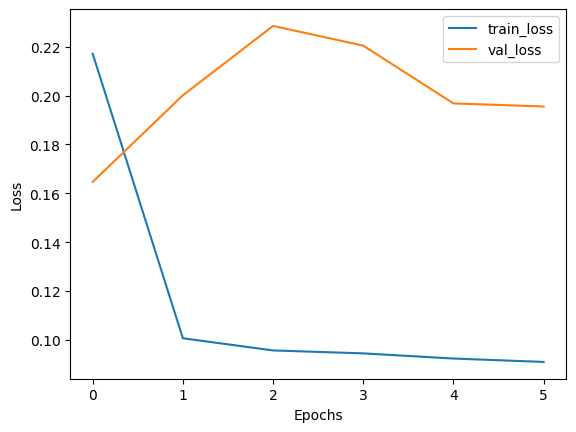

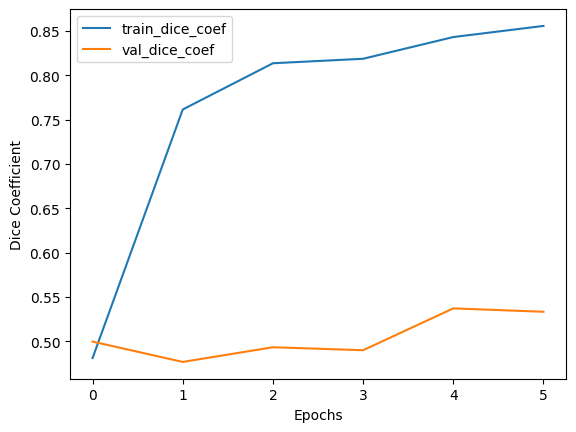

In [31]:
#Faig gràfics per veure com entrena el model2
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history2.history['dice_coef'], label='train_dice_coef')
plt.plot(history2.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

1/1 [==============================] - 1s 656ms/step


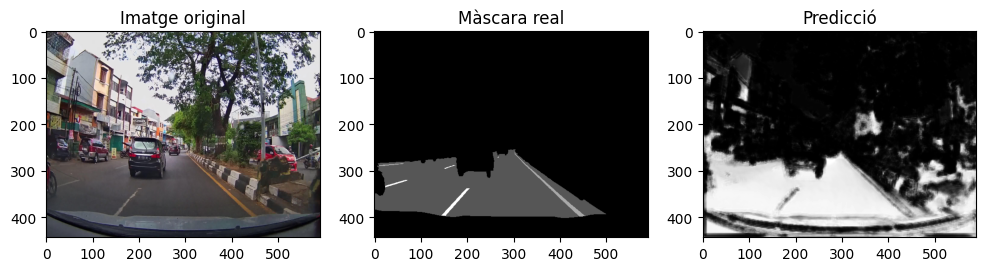

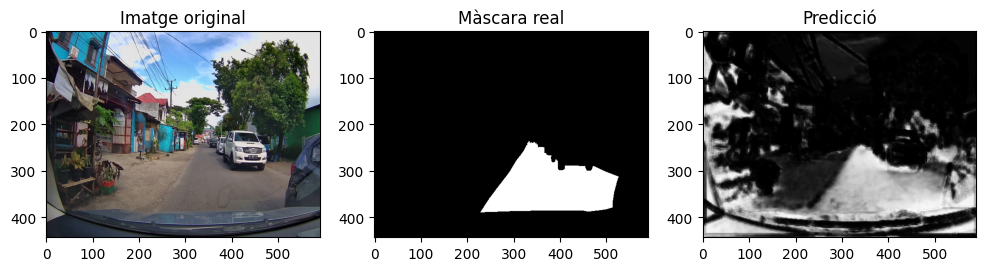

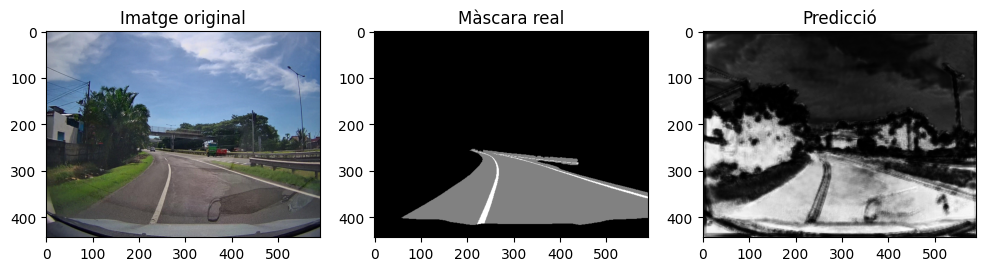

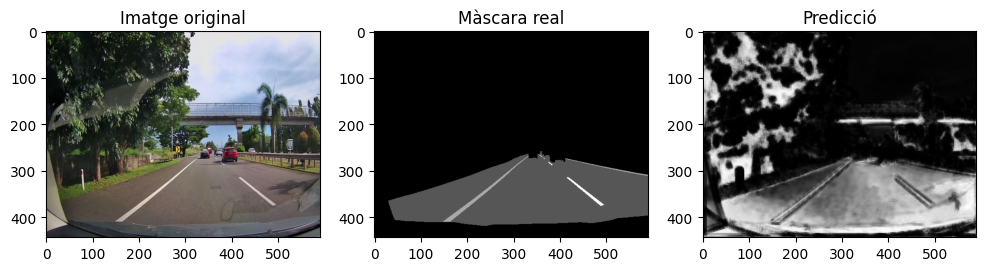

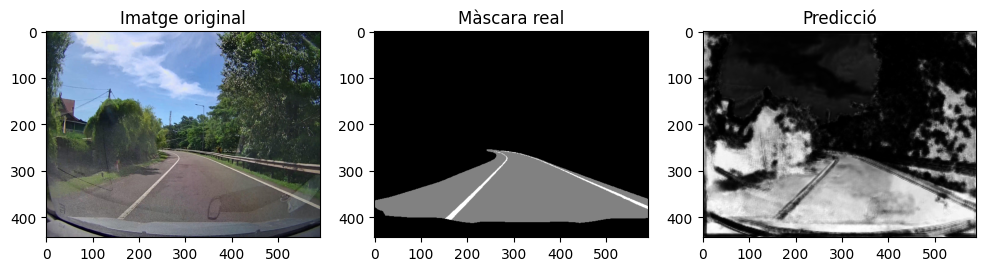

In [32]:
#comprovo com funciona el model2
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred2 = model2.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred2[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()


1/1 [==============================] - 0s 23ms/step


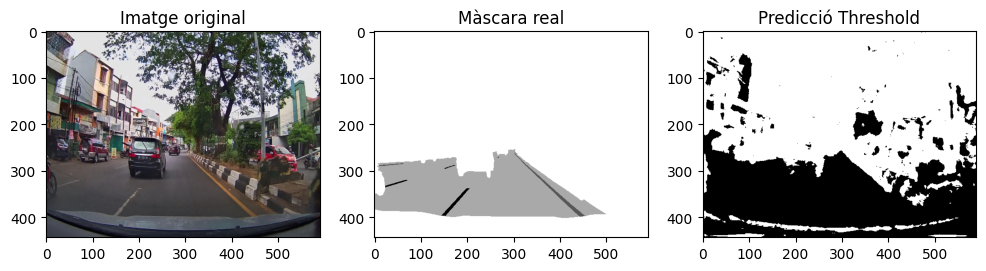

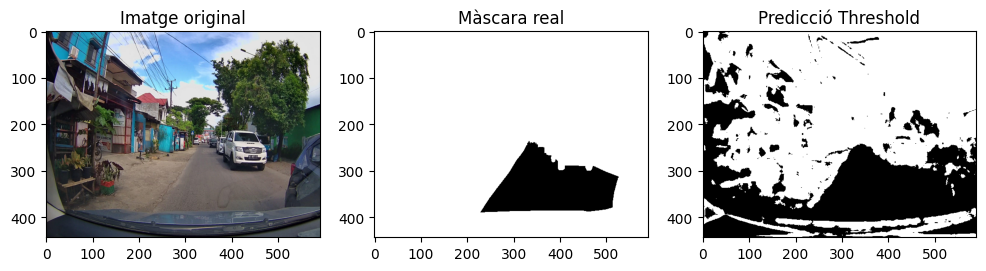

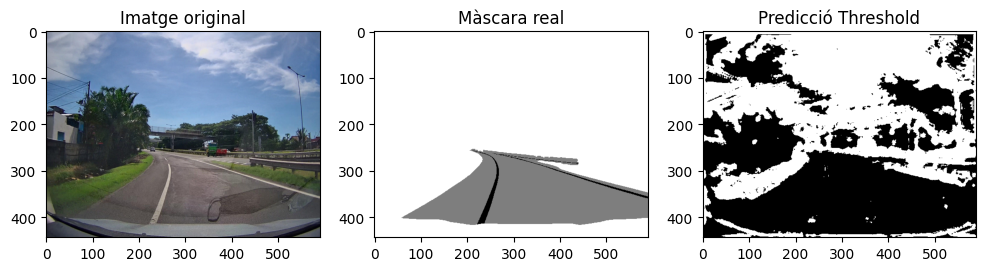

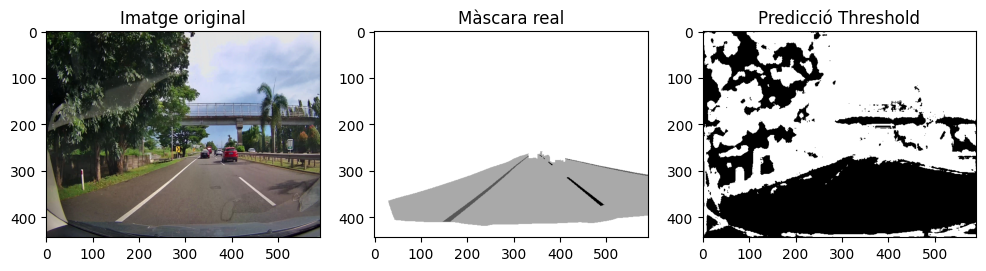

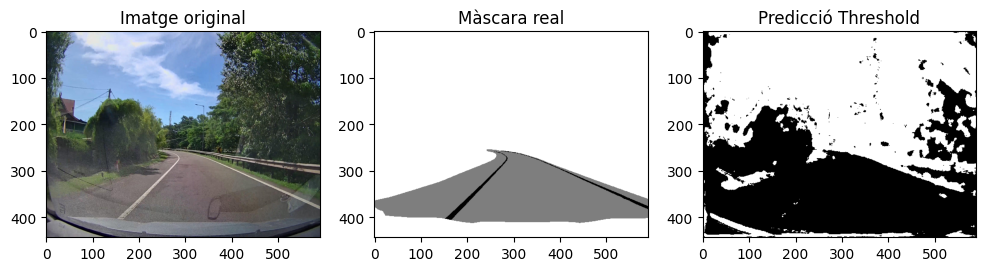

In [33]:
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]

sample_masks_pred2_th = model2.predict(np.array(sample_images))

for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='binary')
    plt.title('Màscara real')

   
    imagen_prediccion_pil = sample_masks_pred2[i]
    imagen_prediccion_np = np.array(imagen_prediccion_pil)

   
    threshold = 0.07
    imagen_threshold = np.where(imagen_prediccion_np > threshold, 255, 0).astype(np.uint8)

    plt.subplot(1, 3, 3)
    plt.imshow(imagen_threshold, cmap='binary')
    plt.title('Predicció Threshold')

    plt.show()
    plt.show()

In [34]:
# Model 3

In [35]:
# Train the model
history3=model3.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


Epoch 1/50
38/38 [==============================] - 51s 914ms/step - loss: 0.2006 - dice_coef: 0.5582 - val_loss: 0.2554 - val_dice_coef: 0.4300
Epoch 2/50
38/38 [==============================] - 30s 780ms/step - loss: 0.0967 - dice_coef: 0.8105 - val_loss: 0.4221 - val_dice_coef: 0.3424
Epoch 3/50
38/38 [==============================] - 29s 772ms/step - loss: 0.0915 - dice_coef: 0.8579 - val_loss: 0.4852 - val_dice_coef: 0.3153
Epoch 4/50
38/38 [==============================] - 29s 771ms/step - loss: 0.0897 - dice_coef: 0.8721 - val_loss: 0.4333 - val_dice_coef: 0.3682
Epoch 5/50
38/38 [==============================] - 29s 775ms/step - loss: 0.0886 - dice_coef: 0.8821 - val_loss: 0.4561 - val_dice_coef: 0.3277
Epoch 6/50
38/38 [==============================] - 29s 773ms/step - loss: 0.0880 - dice_coef: 0.8908 - val_loss: 0.3301 - val_dice_coef: 0.3825


In [36]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 444, 590, 64)      1792      
                                                                 
 batch_normalization_6 (Bat  (None, 444, 590, 64)      256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 444, 590, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 444, 590, 64)      36928     
                                                                 
 batch_normalization_7 (Bat  (None, 444, 590, 64)      256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 444, 590, 64)     

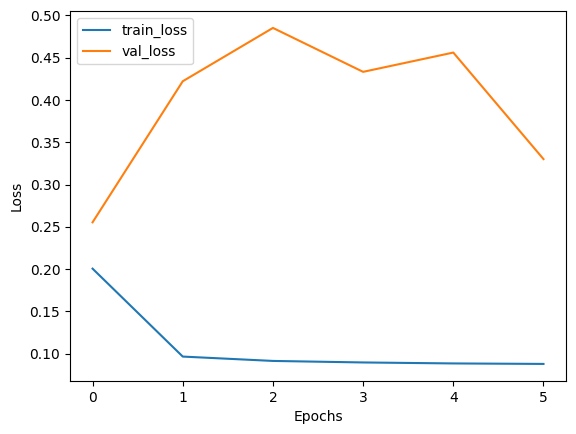

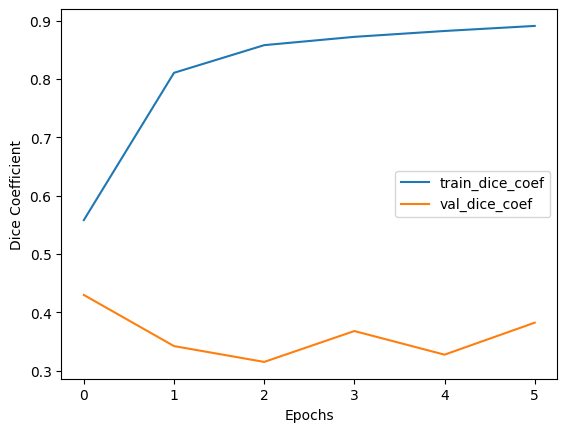

In [37]:
#Faig gràfics per veure com entrena el model3
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history3.history['dice_coef'], label='train_dice_coef')
plt.plot(history3.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step


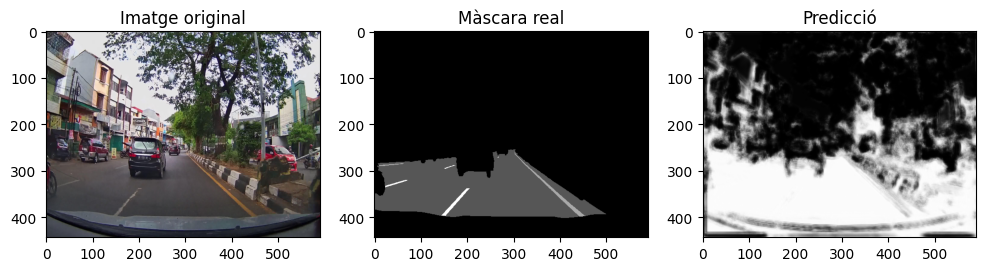

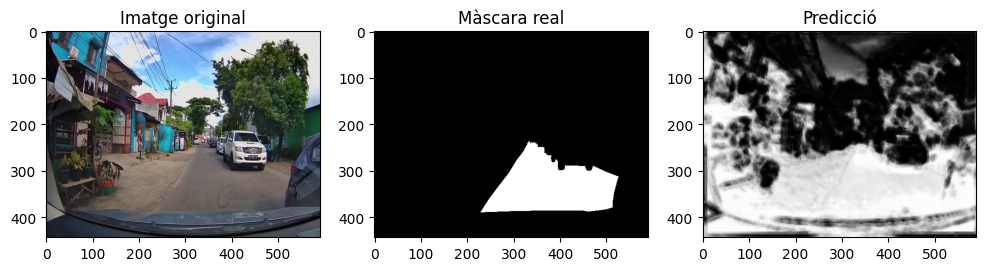

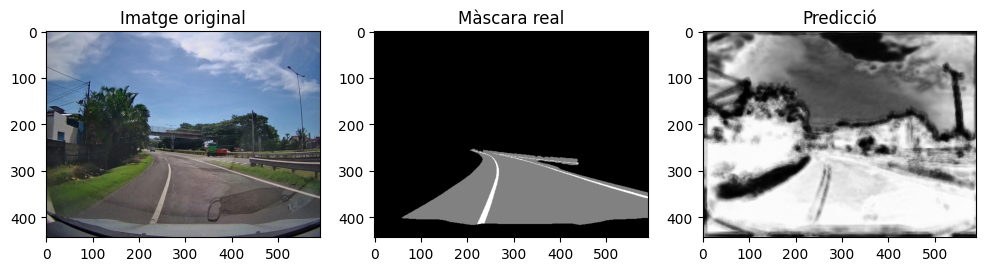

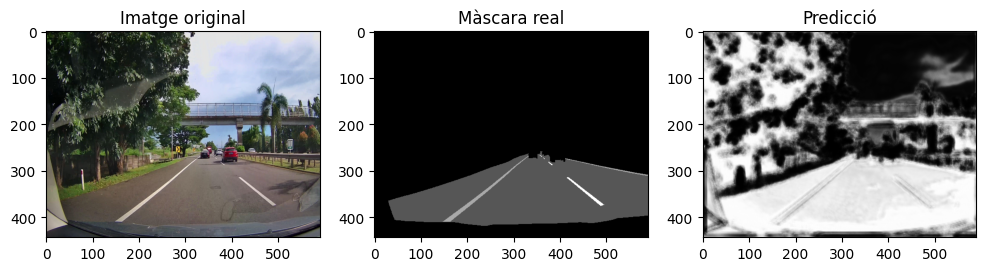

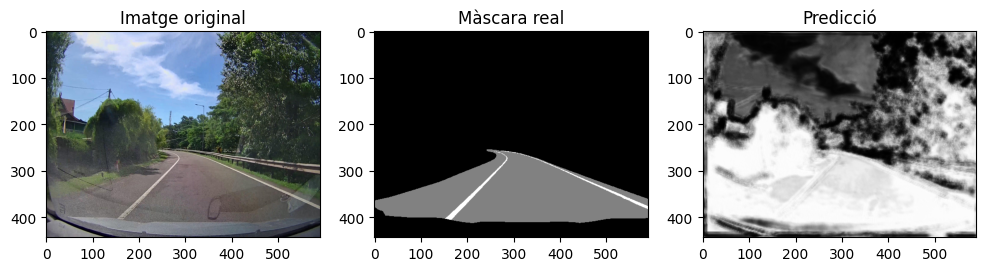

In [38]:
#comprovo com funciona el model3
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred3 = model3.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred3[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()


In [39]:
# SAM

In [40]:
import os 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2


HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q supervision
import supervision as sv

HOME: /kaggle/working
/kaggle/working
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pme5hpk0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pme5hpk0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [41]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/kaggle/working
/kaggle/working/weights
/kaggle/working/weights/sam_vit_h_4b8939.pth ; exist: True


In [42]:
# Carrego imatges de prova:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/kaggle/working
/kaggle/working/data


In [43]:

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"



sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


In [44]:
mask_generator = SamAutomaticMaskGenerator(sam)

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

IMAGE_NAME = f"resized_image_{sample_indices[0]}.png"
IMAGE_PATH =f"/kaggle/working/resized_image{sample_indices[0]}.png"



image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [45]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [46]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

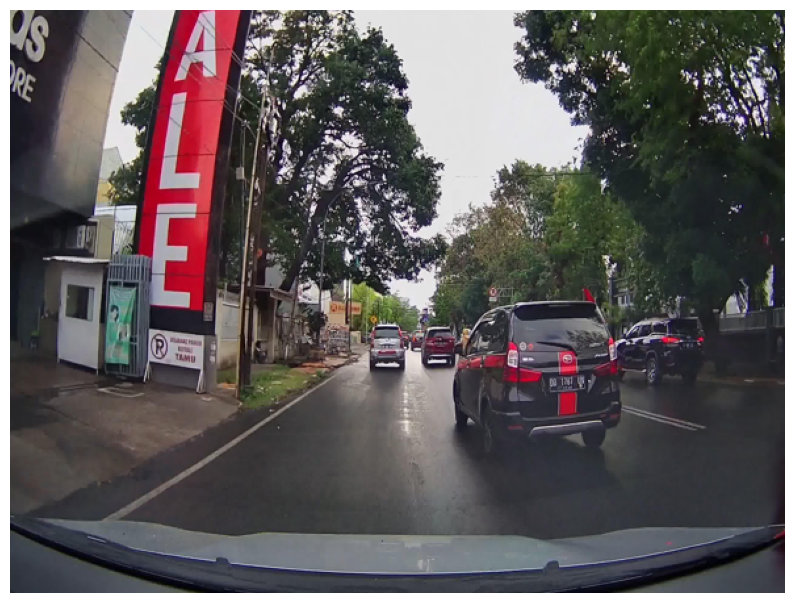

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show() 

In [48]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/working/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:1"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [49]:
masks_sam = mask_generator.generate(image_rgb)

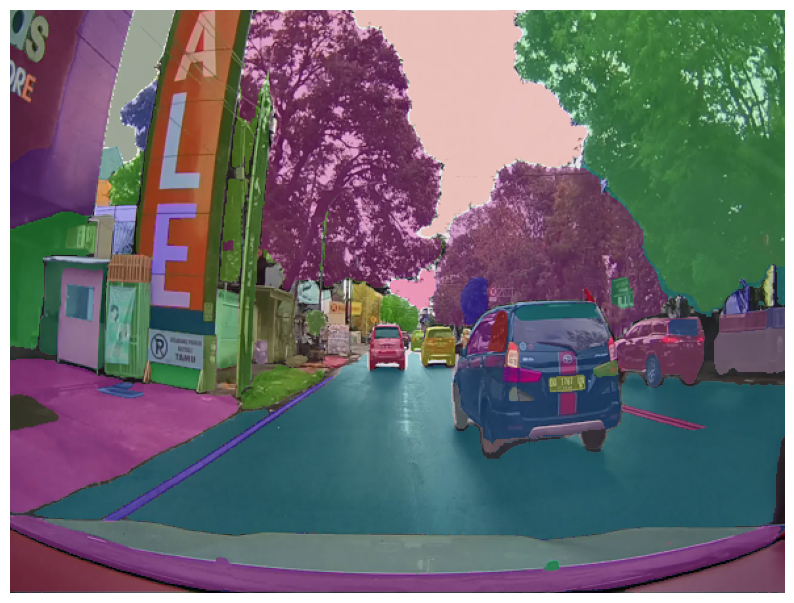

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_anns(masks_sam)
plt.axis('off')
plt.show() 

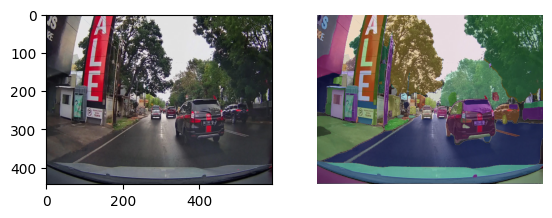

In [51]:
# Miro la imatge i la mascara de sam
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
#plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_anns(masks_sam)
plt.axis('off')
plt.show() 

In [52]:
###### PROVES VARIES###########

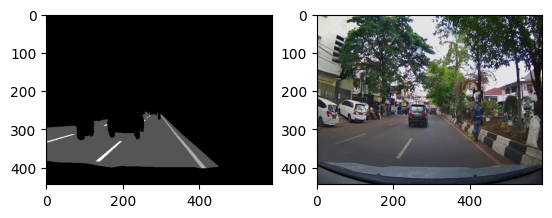

In [53]:
plt.subplot(1,2,1)
image = np.array(Image.open("/kaggle/working/resized_mask1.png"))
image.max()
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
image = np.array(Image.open("/kaggle/working/resized_image5.png"))
image.max()
plt.imshow(image,cmap="gray")

## veig que hi ha problema amb les imatges però no aconsegueixo carregar-les bé, crec que ve del procés de redimensió.

In [54]:

def load_images(image_dir):
    images = {}
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path).convert("RGB"))
            normalized_image = image / 255.0
            image_key = filename.replace("_image.png", "")
            images[image_key] = {'image': normalized_image}

    return images

def load_masks(mask_dir):
    masks = {}
    for filename in os.listdir(mask_dir):
        if filename.endswith(".png") and "mask" in filename:
            mask_path = os.path.join(mask_dir, filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            normalized_mask = mask / 255.0
            mask_key = filename.replace("_mask.png", "")
            masks[mask_key] = {'mask': normalized_mask}

    return masks

In [55]:
#  provar thresholds diferents 

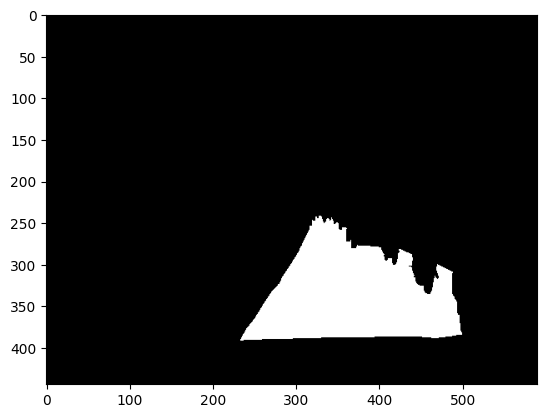

In [56]:
plt.imshow(y_test[10],cmap="gray")


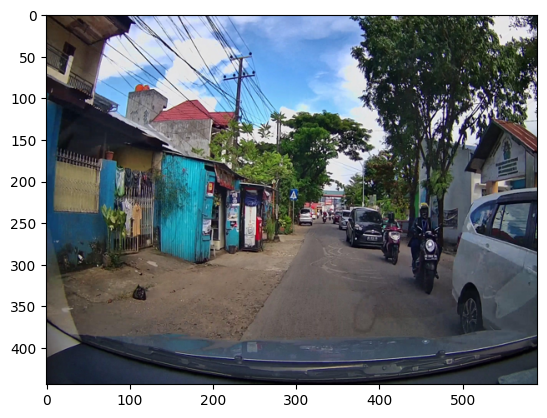

In [57]:
plt.imshow(X_test[10])

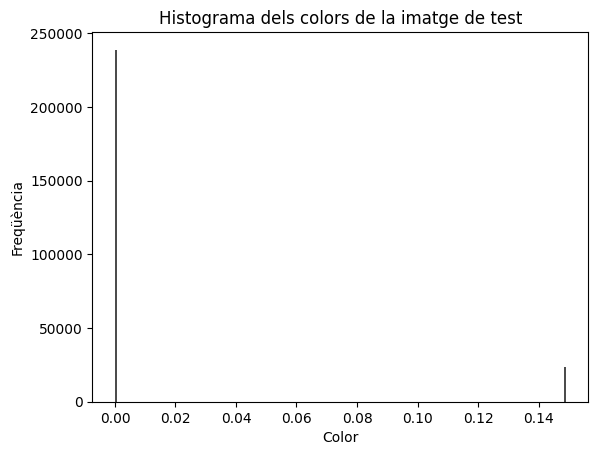

In [58]:
img = y_test[10]
pixels = img.flatten()

plt.hist(pixels, bins=256, color='black', alpha=0.7)

plt.title('Histograma dels colors de la imatge de test')
plt.xlabel('Color')
plt.ylabel('Freqüència')

plt.show()


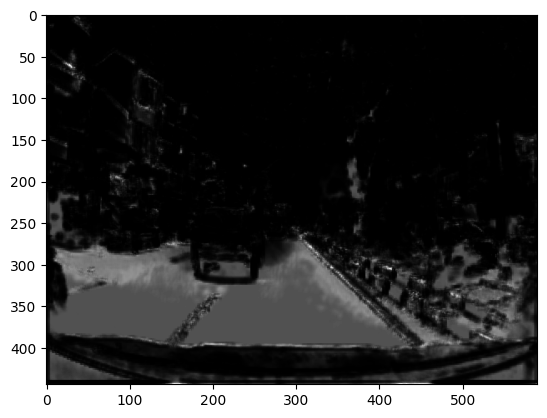

In [59]:
imatge=plt.imshow(sample_masks_pred1[0],cmap="gray")


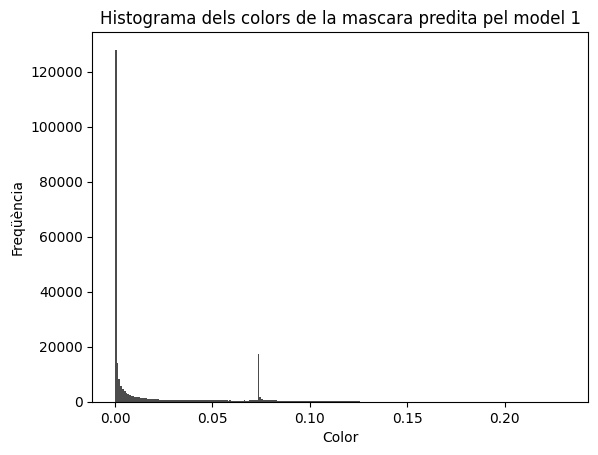

In [60]:
img = sample_masks_pred1[0]

pixels = img.flatten()

plt.hist(pixels, bins=256, color='black', alpha=0.7)

plt.title('Histograma dels colors de la mascara predita pel model 1')
plt.xlabel('Color')
plt.ylabel('Freqüència')

plt.show()



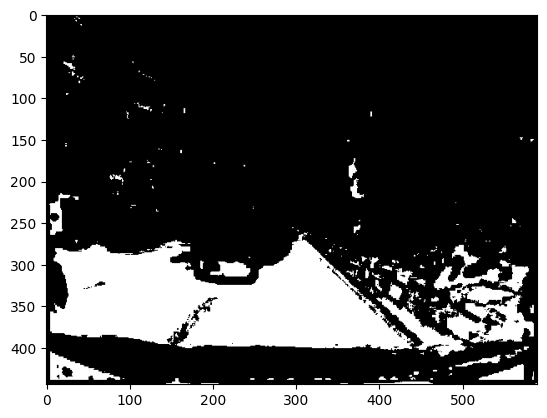

In [61]:
# imatge amb llindar

imagen = sample_masks_pred1[0]

_, imatge_llindar = cv2.threshold(imagen, 0.05, 1, cv2.THRESH_BINARY)

plt.imshow(imatge_llindar, cmap='gray')
plt.show()


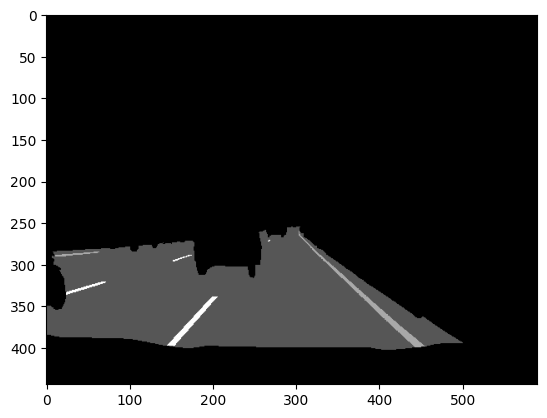

In [62]:
plt.imshow(sample_masks_true[0],cmap="gray")

In [63]:
# predir per totes les imatges de test, fer hist i veure el llindar òptim ytest

In [64]:
y_pred=model.predict(X_test)

3/3 [==============================] - 3s 408ms/step


In [65]:
def trobar_llindar(y_pred, y_test):
    llindars = np.arange(0, 1, 0.01)
    d = []
    lim=[]
    valors=[]
    for th in llindars:
        for i in range(len(y_pred)):
            _, imatge_llindar = cv2.threshold(y_pred[i], th, 1, cv2.THRESH_BINARY)
            valor_dice = dice_coef(imatge_llindar, y_test[i])
            valors.append(valor_dice)
        d.append(np.mean(valors))
        lim.append(th)

    return d,lim

In [66]:
resultats=trobar_llindar(y_pred,y_test)

In [67]:
valors_y=resultats[0]
valors_x=resultats[1]

In [68]:
Index_maxim= valors_y.index(max(valors_y))

valor_maxim_x = valors_x[Index_maxim]

print("El valor del llindar que maximitza el Dice Coefficient és:", valor_maxim_x)

El valor del llindar que maximitza el Dice Coefficient és: 0.05


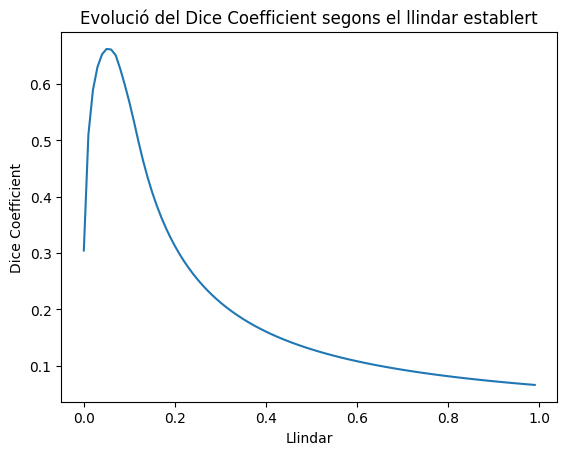

In [69]:
plt.plot(valors_x, valors_y)
plt.xlabel('Llindar')
plt.ylabel('Dice Coefficient')
plt.title('Evolució del Dice Coefficient segons el llindar establert')
plt.show()

In [70]:
def trobar_llindar(y_pred, y_test):
    llindars = np.arange(0, 1, 0.01)
    d = []
    lim=[]
    valors=[]
    for th in llindars:
        for i in range(len(y_pred)):
            _, imatge_llindar = cv2.threshold(y_pred[i], th, 1, cv2.THRESH_BINARY)
            valor_dice = dice_coef(imatge_llindar, y_test[i],th=th)
            valors.append(valor_dice)
        d.append(np.mean(valors))
        lim.append(th)

    return d,lim

In [71]:
resultats_th=trobar_llindar(y_pred,y_test)

In [72]:
valors_y_th=resultats_th[0]
valors_x_th=resultats_th[1]

In [73]:
rang_x_min = 0
rang_x_max = 0.6

#Filtro per trobar el maxim entre els valors que m'interessa
valors_y_filtrats = [valors_y_th[i] for i in range(len(valors_x_th)) if rang_x_min <= valors_x_th[i] <= rang_x_max]
valors_x_filtrats = [valors_x_th[i] for i in range(len(valors_x_th)) if rang_x_min <= valors_x_th[i] <= rang_x_max]

# Encontrar el índice del valor máximo en valores_y_filtrados
Index_maxim_th = valors_y_filtrats.index(max(valors_y_filtrats))

# Encontrar el valor de x correspondiente al valor máximo
valor_maxim_x_th = valors_x_filtrats[Index_maxim]

print("El valor de th que produeix el màxim entre:", rang_x_min, "i", rang_x_max, "és:", valor_maxim_x_th)

El valor de th que produeix el màxim entre: 0 i 0.6 és: 0.05


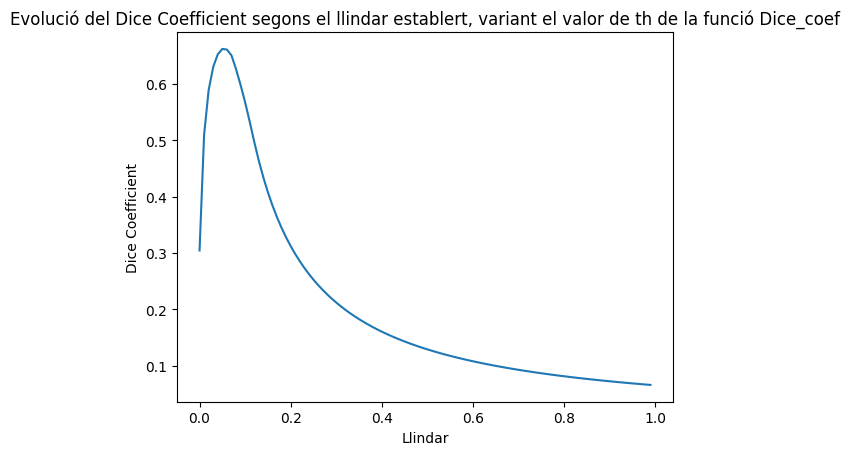

In [74]:
plt.plot(valors_x, valors_y)
plt.xlabel('Llindar')
plt.ylabel('Dice Coefficient')
plt.title('Evolució del Dice Coefficient segons el llindar establert, variant el valor de th de la funció Dice_coef')
plt.show()

(array([[34., 33., 11.,  7.,  3.,  5.,  7.,  0.,  0.,  0.],
        [10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]]),
 array([0.   , 0.099, 0.198, 0.297, 0.396, 0.495, 0.594, 0.693, 0.792,
        0.891, 0.99 ]),
 <a list of 2 BarContainer objects>)

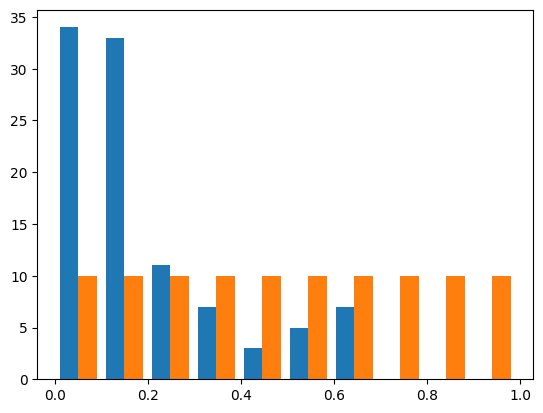

In [75]:
plt.hist(resultats)

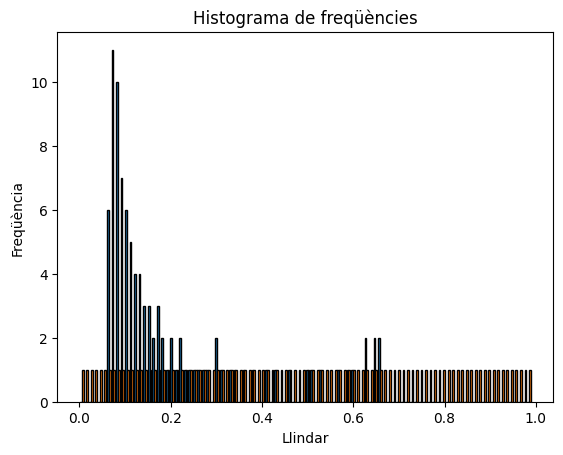

In [76]:

plt.hist(resultats, bins=100, edgecolor='black')
plt.xlabel('Llindar')
plt.ylabel('Freqüència')
plt.title('Histograma de freqüències')
plt.show()

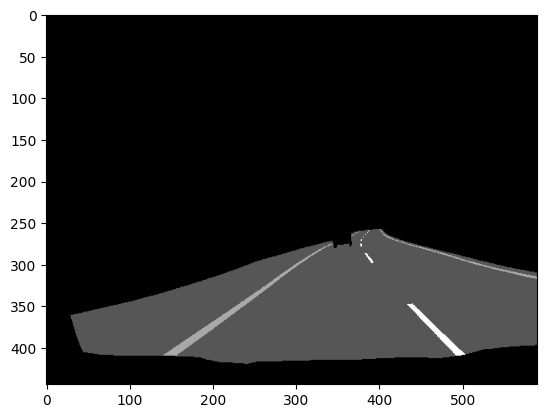

In [77]:
plt.imshow(y_test[0],cmap="gray")

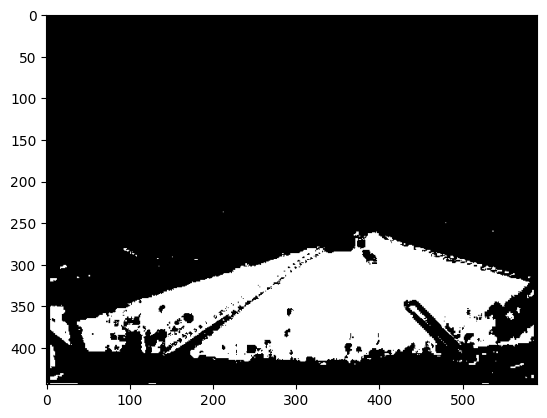

In [78]:
plt.imshow(y_pred[0],cmap="gray")
dice_coef(y_test[0],y_pred[0],th=0.07)
_, imatge_llindar = cv2.threshold(y_pred[0], 0.07, 1, cv2.THRESH_BINARY)
plt.imshow(imatge_llindar,cmap="gray")